# Decision Trees

**Goal:** Learn how **Decision Trees** work in practice and how to interpret a model. First we will explore simple synthetic data of three variables.  

### **Tasks: (10 minutes)**
1. Change the seed to generate different data distributions. 
2. Play with the number of informative and redundant groups. 
3. I will ask a group to discuss and explain the notebook as well as their findings.

### 0) Setup

In [1]:
import numpy as np # For numerical operations
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For plotting
from sklearn.tree import DecisionTreeClassifier # For decision tree classification
from sklearn.datasets import make_classification # For generating a synthetic dataset
from sklearn.model_selection import train_test_split # For splitting data for training
from sklearn.tree import DecisionTreeRegressor, plot_tree # For decision tree visualization
np.random.seed(42) # For making results reproducible

### 1) Create a simple binary classification dataset with three features

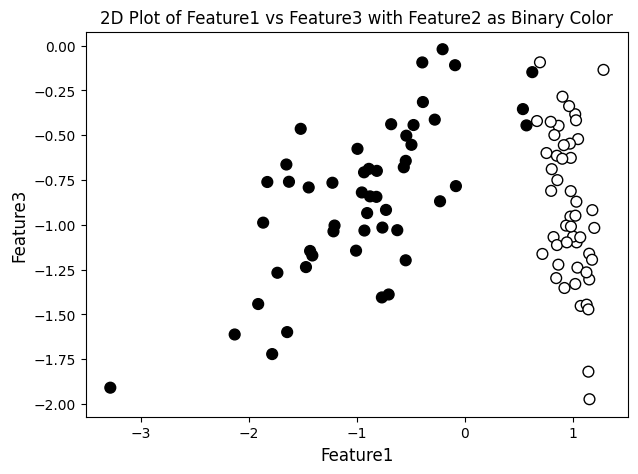

In [2]:
# Generate a dataset with two informative features and one less informative feature
X, y = make_classification(n_samples=100, n_features=3, n_informative=2, n_redundant=1, 
                           n_clusters_per_class=1, n_classes=2, random_state=45)

# Convert to a DataFrame for easier manipulation and naming
df = pd.DataFrame(X, columns=['Feature1', 'Feature2', 'Feature3'])
df['Target'] = y

# Make Feature2 binary to represent a color distinction
df['Feature2'] = (df['Feature2'] > df['Feature2'].median()).astype(int)

# Plot Feature1 vs Feature3 with color indicating the binary Feature2
plt.figure(figsize=(7, 5))
scatter = plt.scatter(df['Feature1'], df['Feature3'], c=df['Feature2'], cmap='binary', edgecolor='k', s=60)

# Add labels and color bar
plt.xlabel('Feature1', fontsize=12)
plt.ylabel('Feature3', fontsize=12)
plt.title('2D Plot of Feature1 vs Feature3 with Feature2 as Binary Color', fontsize=12)
plt.show()

### 2) Train a decision tree

In [3]:
# Split the data into training and testing sets
X = df[['Feature1', 'Feature2', 'Feature3']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

# Initialize and train the decision tree classifier
tree = DecisionTreeClassifier(random_state=42);
tree.fit(X_train, y_train);

# Quick evaluation
pred_val = tree.predict(X_test)
print("Accuracy on test set:", int(tree.score(X_test, y_test) * 100),'%')

Accuracy on test set: 90 %


### 3) Plot decision tree

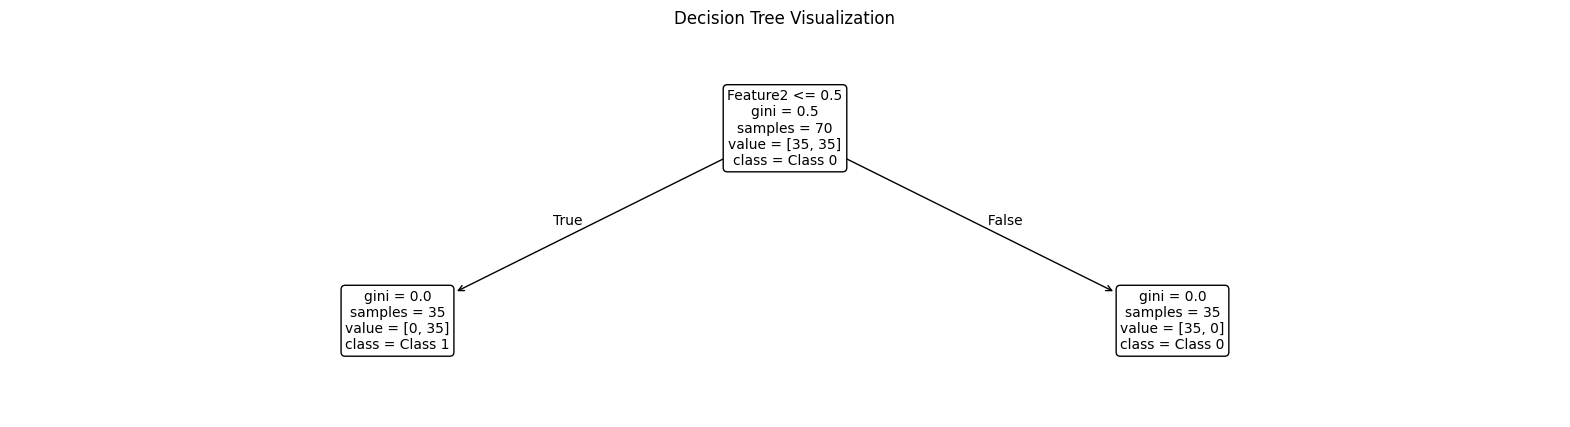

In [4]:
plt.figure(figsize=(20, 5))
plot_tree(tree, 
          feature_names=['Feature1', 'Feature2', 'Feature3'], 
          class_names=['Class 0', 'Class 1'], 
          filled=False, 
          rounded=True, 
          impurity=True, 
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

### 4) Calculate feature importance

In [5]:
# Retrieve feature importances
feature_importances = tree.feature_importances_ # This is a measure of how important each feature is for the decision tree's predictions.

# Display feature importances alongside feature names
importance_df = pd.DataFrame({'Feature': ['Feature1', 'Feature2', 'Feature3'],'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

Feature Importances:
    Feature  Importance
1  Feature2         1.0
0  Feature1         0.0
2  Feature3         0.0


# Partial Dependency and Individual Conditional Expectation Plots

In this notebook, you will explore Partial Dependency (PDP) and Individual Conditional Expectation (ICE) plots. You will work with the following dataset and model:

**Bike Rental Dataset (bike_sharing_data.csv) and Model (bike_sharing_model.pkl)**  
   - This dataset includes four features: `temp`, `feel_temp`, `humidity`, and `windspeed`.  
   - Each feature influences the number of bike rentals differently.  
   - You will **manually replicate PDP and ICE plots** from `sklearn` to understand these concepts deeply.

<img src="./static/bike.png" alt="LO1 Image" style="width: 30%; height: auto;">

---

### **Tasks:**
- **1.1** | Manually compute and plot the **PDP curve** for the target feature `temp`.
- **1.2** | Manually compute and plot the **ICE curves** for `temp`.
- **1.3** | **Center** the ICE curves and plot them along with their average.
- **1.4** | **Discuss** your results and insights.

By the end of this notebook, you should have a strong understanding of how PDP and ICE plots provide insights into model behavior and their limitations in different contexts.


### 0) Setup 

In [6]:
import pandas as pd # For data manipulation
import matplotlib.pyplot as plt # For plotting
import joblib # For saving and loading models from sklearn
from sklearn.inspection import PartialDependenceDisplay # For displaying partial dependence plots and individual conditional expectation
import warnings # Filter warnings
warnings.filterwarnings("ignore")

### 1) Load model and data

In [7]:
model = joblib.load('../models/bike_sharing_model.pkl')
data = pd.read_csv('../data/bike_sharing_data.csv')
data.head() # Show the first 5 rows/instances of the data

,temp,feel_temp,humidity,windspeed
0,14.76,18.940,0.66,0.0000
1,11.48,14.395,0.81,7.0015
2,12.30,15.910,0.81,7.0015
3,18.86,22.725,0.51,19.9995
4,18.04,21.970,0.62,19.9995


### 2) Use sklearn's built-in function to plot the ICE and PDP

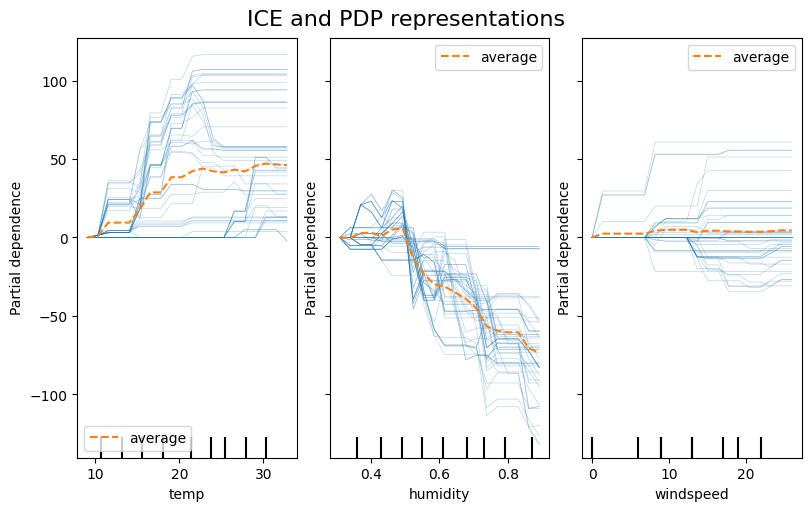

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(8, 5), sharey=True, constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model, # Pre-trained gradient boosed regressor tree model
    data, # Data to plot
    features=["temp", "humidity", "windspeed"], # Features to plot from the dataframe
    kind="both",  # This will plot both PDP and ICE
    centered=True, # Center the ICE curves becaue we are only interested in the shape of the curve not the absolute values
    subsample=50, # Subsample the data to speed up the plotting, we only plot 50 instances
    n_jobs=2, # Use 2 cores to speed up the computation
    grid_resolution=20, # Number of points in the grid, the higher the better the resolution
    random_state=0, # Set the random state for reproducibility
    ax=ax) # Plot the ICE and PDP on the same axis
display.figure_.suptitle("ICE and PDP representations", fontsize=16) # Set the title of the plot
plt.show() # Show the plot
plt.close() # Close the plot to free up memory

### 3) Calculate the PDP for a feature of interest

In [9]:
feature_name = "temp" # Name of the feature of interest

In [10]:
# 1. Get the sorted, unique values of our feature. This will be the x-axis. (one line)
x_values = sorted(data[feature_name].unique())

# 2. Calculate the average prediction for each unique value.
pdp_values = []
for value in x_values:
    # Create a *copy* of the data
    data_modified = data.copy()
    
    # Set the entire feature column to this one value
    data_modified[feature_name] = value
    
    # Get predictions for the modified data
    predictions = model.predict(data_modified)
    
    # Get the average prediction and add it to our list
    pdp_values.append(predictions.mean())

# Now, pdp_values contains the y-axis of our plot

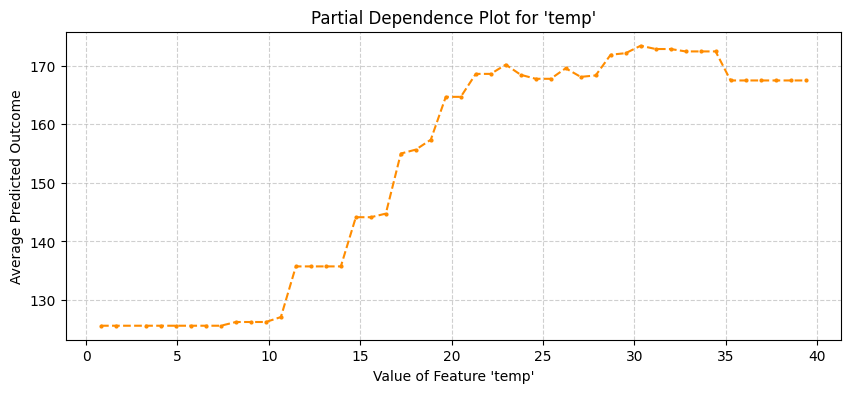

In [11]:
# Create a new plot
plt.figure(figsize=(10, 4))
# Plot the feature values (x-axis) vs. the average predictions (y-axis)
plt.plot(x_values, pdp_values, marker='o', linestyle='--', c='darkorange', markersize=2)
# Add titles and labels for clarity
plt.title(f"Partial Dependence Plot for '{feature_name}'")
plt.ylabel("Average Predicted Outcome")
plt.xlabel(f"Value of Feature '{feature_name}'")
# Add a grid for easier reading
plt.grid(True, linestyle='--', alpha=0.6)
# Display the plot
plt.show()

### 4) Calculate the ICE curves for 50 samples

In [12]:
# 1. Select a few random instances from the dataset to plot
n_ice_samples = 50
ice_samples = data.sample(n=n_ice_samples, random_state=42) # Use random_state for reproducibility

# 2. Define the grid of feature values (our x-axis, same as for the PDP)
x_values = sorted(data[feature_name].unique())

# 3. For each sampled instance, calculate its individual prediction curve
ice_curves = []
for _, instance in ice_samples.iterrows():
    # Create a new DataFrame by repeating the current instance for each x_value
    # This is a much simpler way to create the temporary data
    prediction_data = pd.DataFrame([instance] * len(x_values))
    
    # Now, replace the feature's column with the range of x_values
    prediction_data[feature_name] = x_values
    
    # Make predictions. It's good practice to ensure column order is what the model expects.
    predictions = model.predict(prediction_data[model.feature_names_in_])
    
    # Add the curve for this instance to our list
    ice_curves.append(predictions)

# Convert the list of curves into a 2D NumPy array for easier plotting
ice_curves = np.array(ice_curves)

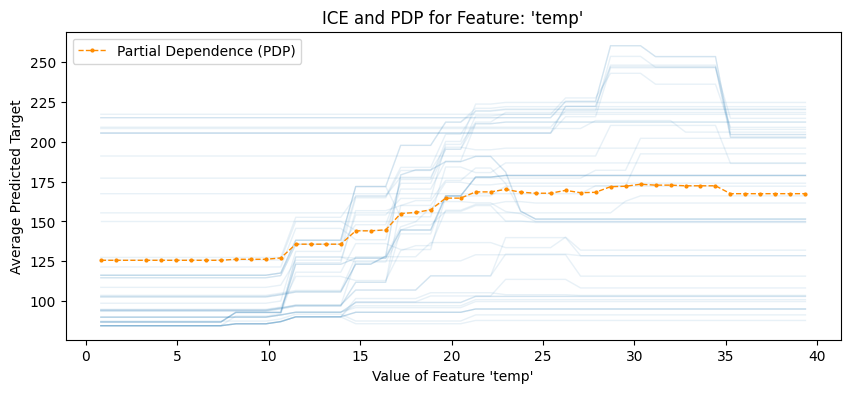

In [13]:
plt.figure(figsize=(10, 4))
# Plot each curve with some transparency (alpha)
for curve in ice_curves:
    plt.plot(x_values, curve, color='#1f77b4', alpha=0.1, linewidth=1.0)
# Plot the PDP line on top, with a stronger color and line
plt.plot(x_values, pdp_values, color='darkorange', linewidth=1.0, marker='o', linestyle='--', markersize=2, label='Partial Dependence (PDP)')
# --- Add titles and labels ---
plt.title(f"ICE and PDP for Feature: '{feature_name}'")
plt.xlabel(f"Value of Feature '{feature_name}'")
plt.ylabel("Average Predicted Target")
plt.legend()
plt.show()

### 5) Center the ICE curves and plot the results as well as the average on the same axes

It is often difficult to interpret ICEs because the plot is unorderly. Since we are only interested in trends and not absolute values, i.e., does the predicted target increase, decrease, or remain the same as we vary the input. One way to center the ICE is to subtract a constant baseline. Selecting the baseline as the predicted value when selecting the anchor as the smallest feature value will ensure all ICE curves start from zero.

In [17]:
# 1. Choose the anchor point. This is the value where all curves will start.
#    Let's use the first unique value of the feature, same as before.
anchor_value = x_values[0] # Assumes x_values is sorted

# 2. Prepare the data for a single, vectorized prediction.
#    We take our original 50 samples and set the feature column to the anchor value.
anchor_data = ice_samples.copy()
anchor_data[feature_name] = anchor_value  # Should be (50, number_of_features)

# 3. Get all anchor predictions in a single call to the model.
#    This is much faster than predicting in a loop!
anchor_predictions = model.predict(anchor_data[model.feature_names_in_])  # Should be (50,)

# 4. Center the ICE curves using NumPy broadcasting.
#    This subtracts each instance's anchor prediction from its entire curve.
#    np.newaxis reshapes the predictions array to make the subtraction work correctly.
centered_ice_curves = ice_curves - anchor_predictions[:, np.newaxis]

(50,)


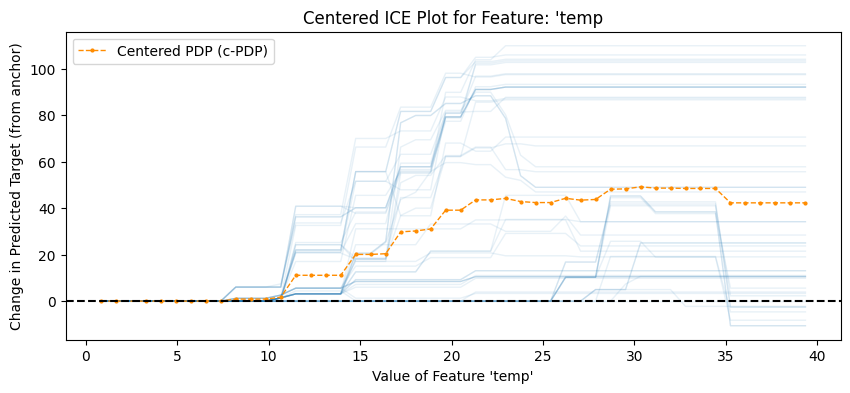

In [15]:
plt.figure(figsize=(10, 4))
# Plot the centered ICE curves
for curve in centered_ice_curves:
    plt.plot(x_values, curve, color='#1f77b4', alpha=0.1, linewidth=1.0)
# The PDP is the average of the ICE curves, so we can average the centered curves too.
centered_pdp = centered_ice_curves.mean(axis=0)
plt.plot(x_values, centered_pdp, color='darkorange', linewidth=1.0, linestyle='--', marker='o', markersize=2, label='Centered PDP (c-PDP)')
# Add a horizontal line at y=0 to emphasize the anchor point
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
# Add titles and labels
plt.title(f"Centered ICE Plot for Feature: '{feature_name}")
plt.xlabel(f"Value of Feature '{feature_name}'")
plt.ylabel("Change in Predicted Target (from anchor)")
plt.legend()
plt.show()